In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.utils.data import Dataset

import pandas as pd
import matplotlib.pyplot as plt
import gcsfs
import numpy as np
import xarray as xr

In [2]:
gen = np.random.default_rng(951241)

In [3]:
perm = gen.permutation(262)
ens = np.array(perm)
ens[np.where(perm >= 175)] = ens[np.where(perm >= 175)] + 1

train_indx = perm[0:210]
test_indx = perm[210: ]

train_ens = ens[0:210]
test_ens = ens[210: ]

In [4]:
torch.manual_seed(5991093)

In [5]:
fs = gcsfs.GCSFileSystem()

In [6]:
param_xr = xr.open_dataset('parameter_262_w_control.nc')

In [7]:
param_df = param_xr.to_pandas()
param_df = param_df.drop('Sample_nmb', axis=1).drop(175, axis=0)

In [8]:
param_df = (param_df - param_df.min()) / (param_df.max() - param_df.min())

In [9]:
param_df.reset_index()['nmb_sim']

0        0
1        1
2        2
3        3
4        4
      ... 
257    258
258    259
259    260
260    261
261    262
Name: nmb_sim, Length: 262, dtype: int64

In [10]:
glob_mean_precl = xr.open_dataset('glob_mean_precl.nc')

In [11]:
train_precl = glob_mean_precl['PRECL'].values[train_indx, ]
test_precl = glob_mean_precl['PRECL'].values[test_indx, ]

In [12]:
train_precl_rav = np.ravel(train_precl)
test_precl_rav = np.ravel(test_precl)

In [13]:
train_ens_rep = np.repeat(train_ens, repeats=36)
test_ens_rep = np.repeat(test_ens, repeats = 36)

In [14]:
class ParamDataset(Dataset):
    def __init__(self, target_y, ens_labels, param_df):
        self.y = target_y
        self.ensemble = ens_labels
        self.param_df = param_df
    
    def __len__(self):
        return(len(self.y))

    def __getitem__(self, idx):
        target = self.y[idx]
        ens = self.ensemble[idx]
        params = self.param_df.loc[ens].values

        return params, target

In [15]:
train_dataset = ParamDataset(train_precl_rav, train_ens_rep, param_df)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [16]:
device='cpu'

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(45, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )
        self.double()

    def forward(self, x):
        preds = self.linear_relu_stack(x)
        return preds

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=1, bias=True)
  )
)


In [18]:
#https://github.com/Javicadserres/wind-production-forecast/blob/main/src/model/losses.py

class QuantileLoss(nn.Module):
    """
    Calculates the quantile loss function.

    Attributes
    ----------
    self.pred : torch.tensor
        Predictions.
    self.target : torch.tensor
        Target to predict.
    self.quantiles : torch.tensor
    """
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.pred = None
        self.targes = None
        self.quantile = quantile
        
    def forward(self, pred, target):
        """
        Computes the loss for the given prediction.
        """
        error = target - pred
        over =  self.quantile * error
        under = (1 - self.quantile) * -error 

        losses = torch.max(over, torch.tensor(0)) + torch.max(under, torch.tensor(0))
        loss = torch.mean((losses))
        return loss

In [19]:
loss_fn = QuantileLoss(0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), (batch + 1) * len(X)

In [21]:
epochs = 500
for t in range(epochs):
    if t % 20 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
Epoch 21
-------------------------------
Epoch 41
-------------------------------
Epoch 61
-------------------------------
Epoch 81
-------------------------------
Epoch 101
-------------------------------
Epoch 121
-------------------------------
Epoch 141
-------------------------------
Epoch 161
-------------------------------
Epoch 181
-------------------------------
Epoch 201
-------------------------------
Epoch 221
-------------------------------
Epoch 241
-------------------------------
Epoch 261
-------------------------------
Epoch 281
-------------------------------
Epoch 301
-------------------------------
Epoch 321
-------------------------------
Epoch 341
-------------------------------
Epoch 361
-------------------------------
Epoch 381
-------------------------------
Epoch 401
-------------------------------
Epoch 421
-------------------------------
Epoch 441
-------------------------------
Epoch 461
------------------------------

In [22]:
with torch.no_grad():
    test_out = model(torch.tensor(param_df.loc[test_ens].to_numpy()))

In [23]:
test_params = param_df.loc[test_ens].to_numpy()
test_params_reps = np.repeat(test_params, repeats=36, axis=0)

In [24]:
with torch.no_grad():
    test_out_long = model(torch.tensor(test_params_reps))

In [25]:
glob_mean_precl['PRECL']

<xarray.DataArray 'PRECL' (ensemble: 262, time: 36)> Size: 75kB
array([[1.564141, 1.495635, 1.457315, ..., 1.529119, 1.478577, 1.482843],
       [1.343186, 1.290355, 1.209211, ..., 1.257928, 1.243958, 1.277287],
       [2.445758, 2.429173, 2.282414, ..., 2.247864, 2.281629, 2.354787],
       ...,
       [1.598009, 1.526406, 1.500959, ..., 1.432157, 1.526852, 1.570827],
       [0.972967, 0.936732, 0.922137, ..., 0.883175, 0.886784, 0.915985],
       [1.450529, 1.393381, 1.324465, ..., 1.329022, 1.357278, 1.347574]])
Coordinates:
  * ensemble  (ensemble) int64 2kB 0 1 2 3 4 5 6 ... 256 257 258 259 260 261 262
  * time      (time) object 288B 0001-01-16 12:00:00 ... 0003-12-16 12:00:00

In [26]:
test_out.numpy()

array([[0.96896448],
       [1.38828608],
       [0.95423453],
       [2.25575864],
       [1.58764675],
       [1.08779335],
       [1.73090418],
       [1.81632428],
       [2.23877982],
       [1.21089126],
       [2.3675365 ],
       [1.89490088],
       [0.9694686 ],
       [1.76354127],
       [2.45687824],
       [1.84239267],
       [1.37421384],
       [1.27174598],
       [1.27051342],
       [1.54369835],
       [0.88531065],
       [1.05947534],
       [1.33781812],
       [2.12706049],
       [1.17334634],
       [1.73189544],
       [1.4646074 ],
       [2.25986901],
       [1.83490667],
       [1.49850817],
       [1.66642768],
       [1.12978102],
       [1.7122879 ],
       [2.22948729],
       [1.05607671],
       [2.22771255],
       [1.65087943],
       [1.26932718],
       [1.3351379 ],
       [1.62426508],
       [1.84684128],
       [1.36602362],
       [1.33647657],
       [1.24576583],
       [1.4895385 ],
       [1.21364007],
       [1.42207119],
       [1.058

In [27]:
np.corrcoef(test_out.numpy().reshape(52),
            np.quantile(glob_mean_precl['PRECL'].values[test_indx], 0.9, axis=1))

array([[1.        , 0.94849277],
       [0.94849277, 1.        ]])

In [28]:
pred_act_corr = np.corrcoef(test_out.numpy().reshape(52),
                            np.quantile(glob_mean_precl['PRECL'].values[test_indx], 0.9, axis=1))[0, 1]

In [29]:
pred_act_corr**2

0.8996385311041345

In [30]:
test_loss = loss_fn(test_out_long.squeeze(), torch.tensor(test_precl_rav))

In [31]:
test_loss

tensor(0.0400, dtype=torch.float64)

In [32]:
mse_quants = np.mean((np.quantile(glob_mean_precl['PRECL'].values[test_indx], 0.9, axis=1) - test_out.squeeze().numpy())**2)

In [33]:
np.sqrt(np.mean((np.quantile(glob_mean_precl['PRECL'].values[test_indx], 0.9, axis=1) - test_out.squeeze().numpy())**2))

0.1425191070985559

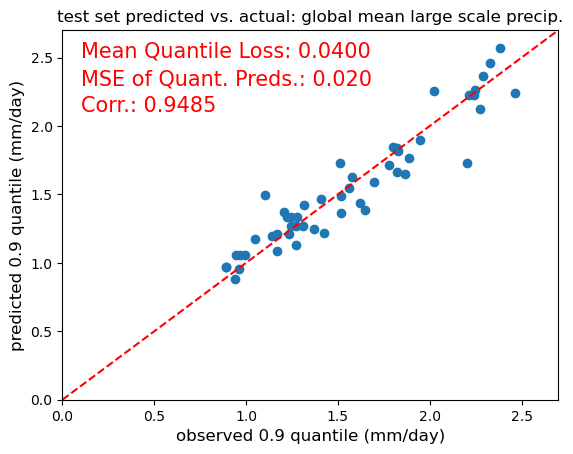

In [39]:
plt.scatter(np.quantile(glob_mean_precl['PRECL'].values[test_indx], 0.9, axis=1),
            (test_out.numpy().reshape(52)))
plt.xlim([0, 2.7])
plt.ylim([0, 2.7])
plt.xlabel('observed 0.9 quantile (mm/day)', size=12)
plt.ylabel('predicted 0.9 quantile (mm/day)', size=12)
plt.text(x=0.1, y=2.5, s=f'Mean Quantile Loss: {test_loss:.4f}', color='red', size=15)
plt.text(x=0.1, y=2.3, s=f'MSE of Quant. Preds.: {mse_quants:.3f}', color='red', size=15)
plt.text(x=0.1, y=2.1, s=f'Corr.: {pred_act_corr:.4f}', color='red', size=15)
plt.axline(xy1=(0,0),slope=1, linestyle='--', color='red')
plt.title('test set predicted vs. actual: global mean large scale precip.')
plt.savefig('glob_nn_pred_vs_test_wd_precl.png')

In [102]:
test_out.squeeze().numpy()

array([1.07503997, 1.43525289, 1.46281423, 1.98155924, 1.109492  ,
       1.85728471, 1.50438853, 1.78447746, 0.53674496, 1.18753188,
       1.13265049, 1.27570834, 1.19803844, 1.91950971, 0.92073601,
       1.42923738, 0.96549647, 0.95407808, 0.62926612, 1.70315513,
       1.74652935, 1.95672312, 1.65175191, 1.53599245, 0.76803278,
       2.03980465, 1.16691753, 2.08888628, 1.75073655, 1.40423827,
       1.34456678, 1.63747388, 0.85767918, 0.62313868, 1.64970165,
       1.79473795, 1.40991437, 1.37247807, 1.73002995, 1.84898897,
       0.9407487 , 1.53369881, 1.77425802, 1.58705453, 0.99290765,
       1.19157865, 1.42321742, 0.66501307, 1.52924539, 1.76996912,
       1.47397003, 1.22478588])

In [99]:
np.quantile(glob_mean_precl['PRECL'].values[test_indx], 0.9, axis=1).shape

(52,)